# *FARADAY ROTATION* | Lab-Session #7
## Apr-1-2021 13:45

Here we perform the analysis of all the measurements

In [59]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as consts
from tqdm import tqdm
import os
from csvlib import *
from scipy.optimize import curve_fit
import matplotlib

# Display mpl in notebook format
%matplotlib inline

# Data Analysis

Here are the functions we used to analyse our data

In [140]:
# First we pick a data set using a folder name
directory = 'AC_VERDET_ROD'     # Directory of the data
angle_correction = 343.81
angle_c          = angle_correction/180*np.pi
pol_angle        = 3.896113 # degrees
pol_angle_rad    = pol_angle/180*np.pi

# Now define some parameters for the experiment
params = {
    'P_max'        : 1e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 1,              # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 1,              # Lock in Gain
    'K_lock_in'    : 1/2,            # Lock in Constant
    'G_lp_amp'     : 1,              # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 1e-2,           # Material length in the solenoid in m
    'Sigma_L'      : 1e-3,           # Uncertainty in Length
}

# print the setup file for this directory
def print_setup(directory=directory):
    file = open(directory+'/Setup.txt')
    lines = file.readlines()
    file.close
    
    for line in lines:
        print(line,end='')

# Returns a data frame for the measurements of that particular angle
def get_angle(angle,directory=directory):
    angle = int(angle)
    data = pd.read_csv(directory+'/Angle-%d.csv'%angle)

    return data.to_numpy().T

# Get the raw data for voltage and amplitude
def get_voltage_vs_amplitude(directory=directory):
    data = pd.read_csv(directory+'/Voltage-Amplitude.csv'%angle)
    return data.to_numpy().T

# Returns average and standard deviation
def get_stats(data):
    return np.mean(data), np.std(data)

# Returns a calculated data set with mean and stds for a set of angles
def voltage_vs_angle(angles=np.linspace(0,360,360,dtype=int),directory=directory,channel=5):
    V = []
    V_std = []
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        mean,std = get_stats(data[channel])

        V.append(mean)
        V_std.append(std)

    return np.array(V),np.array(V_std),angles

# get the raw data for the current among a list of angles
def get_current_ac(angles=np.linspace(0,360,360,dtype=int),directory=directory,channel=1):
    time  = np.array(get_angle(0)[0])
    I     = np.zeros(time.shape)
    I_std = np.zeros(time.shape)
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        I += data[channel]
    
    I = np.array(I)/len(angles)
    I_avg = np.mean(I)
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        I_std += (np.array(data[channel]) - I_avg)**2
    
    I_std /= len(angles)
    
    return I, I_std**0.5, time



# obtain the phase difference and verdet constant due to rotation from the signal amplitude plot
def calc_verdet_ac(voltage,voltage_std,current,current_std,average=0.95,params=params):
    # First calculate the phase shift from the amplitude of the signal
    V_max = np.mean([abs(i) for i in voltage if abs(i)/max(voltage) >= average])
    
    Gain  = params['G_preamp']*params['G_filter']*params['G_lp_amp']*params['G_lock_in']
    K     = params['K_sensor']
    R     = params['R_sensor']
    K_loc = params['K_lock_in']
    P     = params['P_max']
    cor   = params['Correction']
    
    # This is the phase shift
    f = np.sqrt( 2 * V_max / (Gain * K * K_loc * R * P) )
    Delta_phi = np.arcsin(f)*180/np.pi - cor
    
    # To get the phase uncertainty 
    sigma_V = [voltage_std[i]**2 for i in range(len(voltage)) if abs(voltage[i])/max(voltage) >= average]
    sigma_V = (np.sum(sigma_V)/len(sigma_V))**0.5
    sigma_phi = abs(sigma_V/( (1-f**2)**0.5 * f))
    
    
    
    # Now to get the Verdet constant
    I_max = np.mean([abs(i) for i in current if abs(i)/max(current) >= average])
    
    B = params['K_solenoid'] * I_max
    l = params['Length']
    
    Verdet = Delta_phi / (B * l)
    
    # To get the verdet uncertainty
    sigma_I = [current_std[i]**2 for i in range(len(current)) if abs(current[i])/max(current) >= average]
    sigma_I = (np.sum(sigma_I)/len(sigma_I))**0.5
    sigma_I = abs(sigma_I * Verdet/I_max)
    sigma_L = abs(params['Sigma_L']*Verdet/l)
    
    sigma_Verdet = (sigma_I**2 + sigma_L**2 + (sigma_phi/(B*l))**2 )**0.5
    
    # Return the two values
    return Verdet, sigma_Verdet, Delta_phi, sigma_phi
    


# Plot a voltage VS amplitude graph
def plot_VA(angles=np.linspace(0,360,360,dtype=int),V=None,V_std=None,directory=directory,channel=5,title='Lock-in Output VS Angle',average=0.97):

    if type(V) == type(None) or type(V_std) == type(None):
        V,V_std,_ = voltage_vs_angle(directory=directory,channel=channel)

    # Create the figure
    fig = plt.figure(figsize=(15,5),dpi=300)
    ax = fig.add_subplot(111)
    
    # Plot
    ax.errorbar(angles/180,V,yerr=V_std,color='deepskyblue',fmt='.',ms=5,label='Raw Data')
    
    # Make the figure look pretty
    ax.set_xlim(min(angles)/180, max(angles)/180)
    ax.set_ylim(min(V)*1.1,max(V)*1.1)
    grid_x_major = np.arange(min(angles)/180, max(angles)/180, 0.25)
    grid_x_minor = np.arange(min(angles)/180, max(angles)/180, 0.25/5)

    ax.set_title(title)
    ax.set_xlabel(r'Polariser Angle $\theta$ [rad]')
    ax.set_ylabel(r'Lock-in output V [V]')
    
    ax.set_xticks(grid_x_major)
    ax.set_xticks(grid_x_minor,minor=True)
    ax.xaxis.grid(True, which='both')
    ax.grid(which='minor', alpha=0.4, linestyle='--')
    ax.tick_params(axis="both",which="both", direction="in")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
    
    ax.fill_between(angles/180, 2*min(V), 2*max(V), where=(abs(V) > max(V)*average), color='lightskyblue',alpha=0.5,\§
                    label='Maximum Oscillation Areas')

    ax.legend(frameon = False)
    
    return fig,ax

# Plot the lock in at a particular angle
def plot_lock_in(angle,directory=directory):
    data    = get_angle(angle,directory=directory)
    time    = data[2]
    lock_in = data[3]

    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    ax.plot(time,lock_in,color='mediumseagreen')

    return fig,ax

# AC Verdet analyisis
This will perform the analysis for the verdet constant of the ROD done using lock in amplification

100%|██████████| 360/360 [00:00<00:00, 396.80it/s]


[ 3.28913552 -1.57079633 -1.19109075 -1.57079633]
V:	 22.960382524620833 32.72151573695468
φ:	 0.9927193463089989 1.0585153134662897


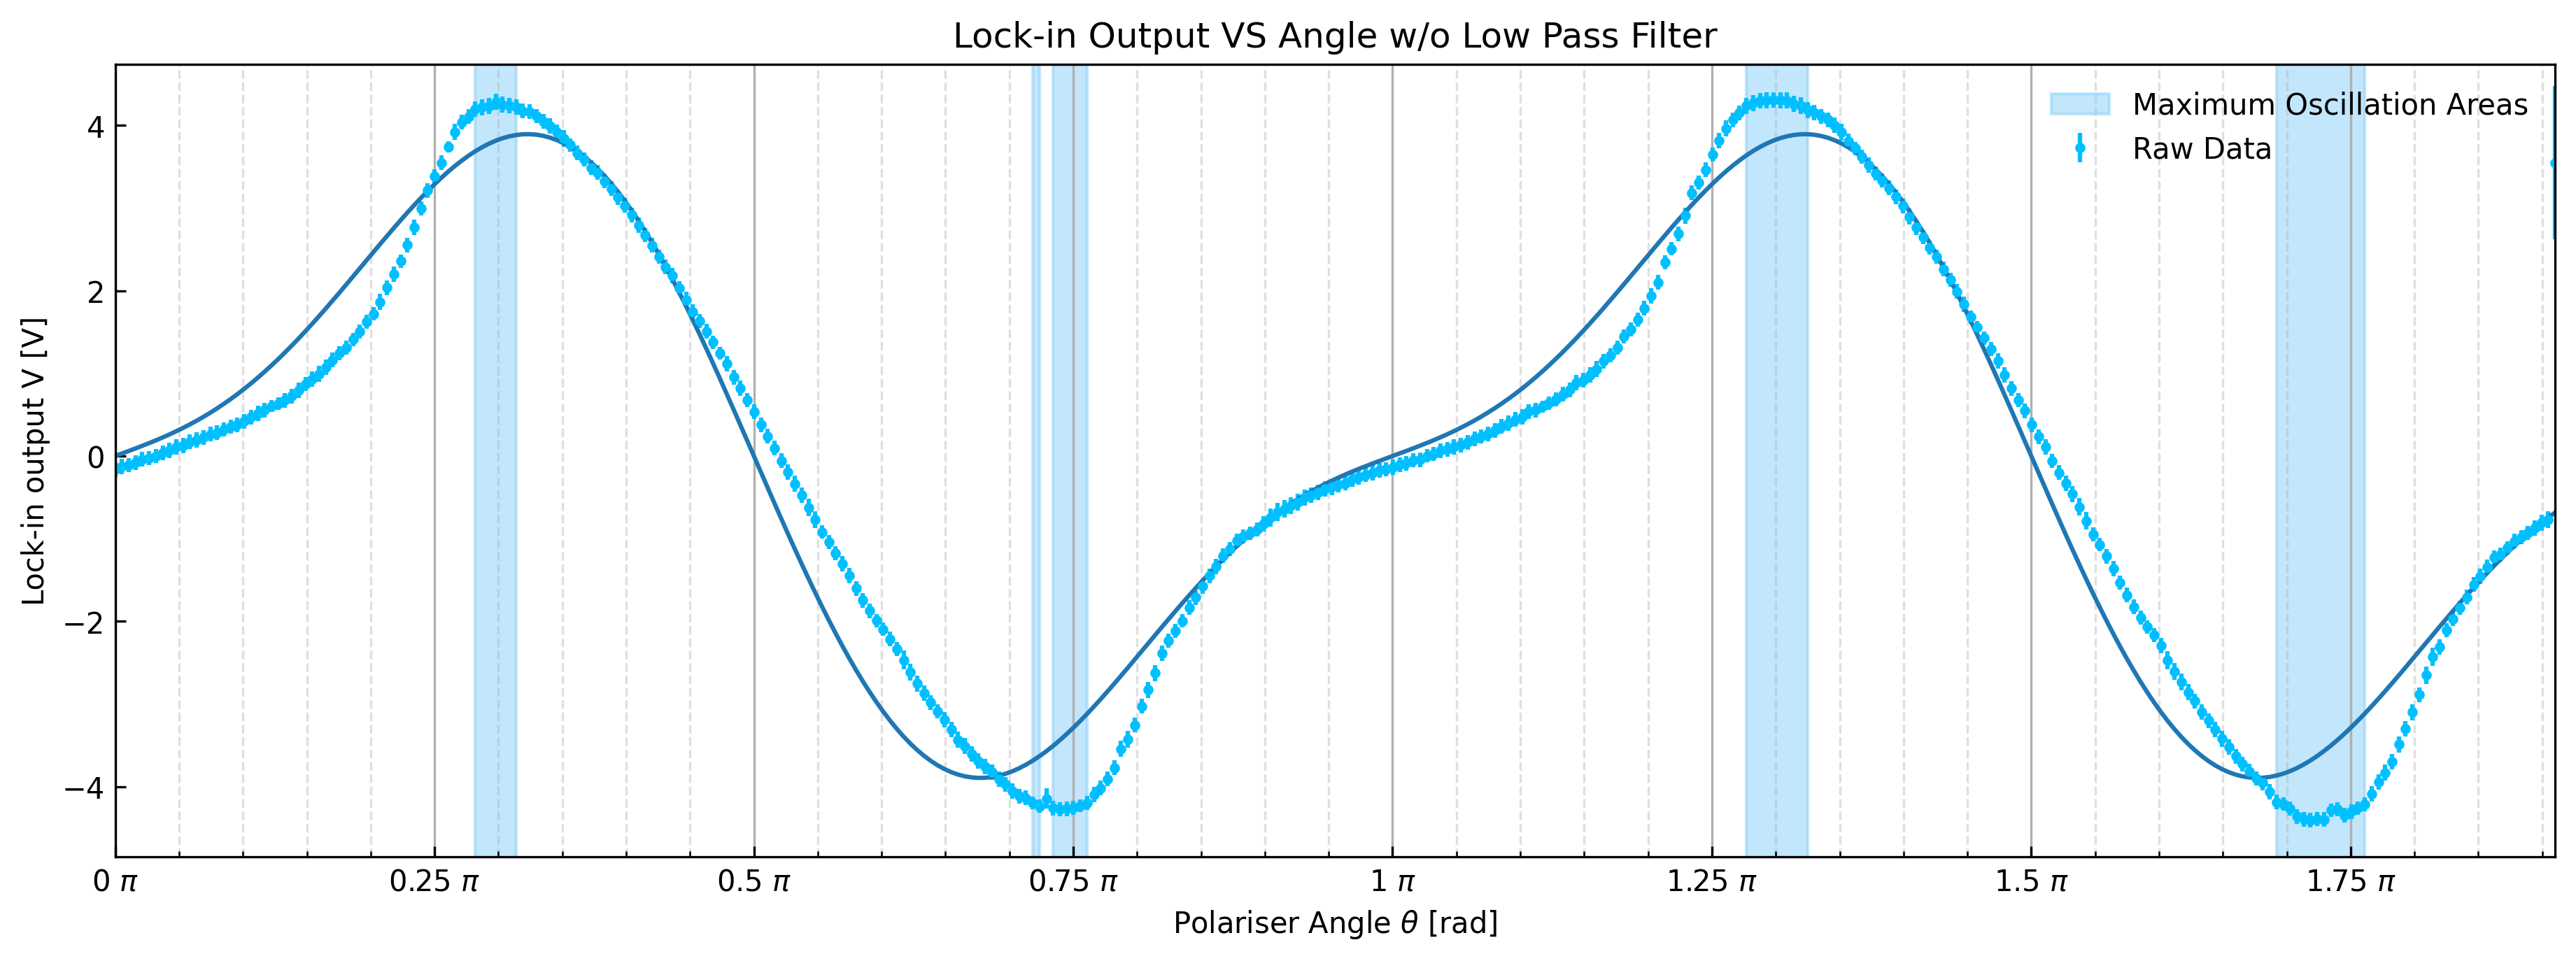

In [155]:
# Set the directory with the measurements
directory = 'AC_VERDET_ROD'

# Set the parameters of the experiment
params = {
    'P_max'        : 1e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 10,             # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 20,             # Lock in Gain
    'K_lock_in'    : 1/2,            # Lock in Constant
    'G_lp_amp'     : 20,             # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 10.175e-2,      # Material length in the solenoid in m
    'Sigma_L'      : 0.005e-2,       # Uncertainty in Length in m
    'Correction'   : pol_angle       # Correction angle to account for the difference of the polarizers
}
angles = np.linspace(0,360,360,dtype=int)

# Get the relevant data
voltage, voltage_std, angles = voltage_vs_angle(directory=directory)
angles = np.linspace(0,angle_correction,360)
voltage -= np.mean(voltage)
current, current_std, time = get_current_ac(angles=angles,directory=directory)

# print_setup(directory)          # Print the setup for the particular experiment

# Plot the voltage VS angle curve
fig,ax = plot_VA(angles=angles,V=voltage,V_std=voltage_std,directory=directory,\
                 title='Lock-in Output VS Angle w/o Low Pass Filter')

# Fit the data
fit = lambda theta, a,c,d,e: a*np.cos(2*theta + c) + d*np.sin(4*theta)
pars, pcov = curve_fit(fit,angles/180*np.pi,voltage,p0=[4,1,2,-np.pi/2],\
                       bounds=([0,-np.pi/2,-5,-np.pi/2],[5,np.pi/2,5,np.pi/2]))

errors = [(pcov[i][i])**0.5 for i in range(len(pars))]

ax.plot(angles/180, fit(angles/180*np.pi,*pars))
print(pars)

# Calculate Verdet constant
V,V_std, Phi,Phi_std = calc_verdet_ac(voltage,voltage_std,current,current_std,average=0.999,params=params)

print("V:\t",V*np.pi/180,V_std*np.pi/180) # 21.0 rad/Tm
print("φ:\t",Phi,Phi_std)